In [ ]:
#Cream dependentele proiectului
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [87]:
#1. Descarcam datele despre s&p500 si le salvam
sp500=yf.Ticker("^GSPC")
sp500=sp500.history(period="max")
sp500.to_csv("data/sp500.csv", index=False)


In [88]:
# 2. Crearea variabilei țintă (predictăm prețul de închidere de mâine)
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500 = sp500.dropna()

In [89]:
# 3. Adăugarea unor noi caracteristici tehnice
sp500["SMA_10"] = sp500["Close"].rolling(window=10).mean()
sp500["SMA_50"] = sp500["Close"].rolling(window=50).mean()
sp500["Volatility"] = sp500["Close"].rolling(window=10).std()
sp500 = sp500.dropna()


In [90]:
# 4. Definirea X și y
X = sp500.drop(columns=["Tomorrow"])
y = sp500["Tomorrow"]

In [91]:
# 5. Împărțirea în seturi de antrenament și test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# 6. Antrenarea modelului XGBoost optimizat
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [93]:
# 7. Evaluarea performanței modelului
y_pred = model.predict(X_test)
xgb_rmse = root_mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R² Score: {xgb_r2:.4f}")

XGBoost RMSE: 18.6419
XGBoost R² Score: 0.9997


In [94]:
# 8. Comparare cu Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_rmse = root_mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse:.4f}")

Random Forest RMSE: 27.9835


In [95]:
# 9. Cross-validation pentru stabilitate
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error")
print(f"Cross-Validation RMSE mediu: {-scores.mean():.4f}")

Cross-Validation RMSE mediu: 18.3790


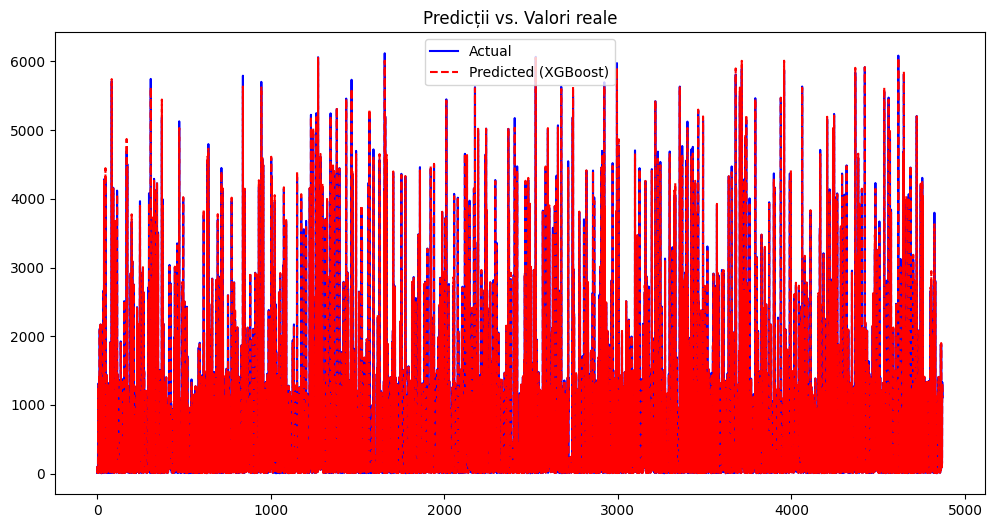

In [96]:
# 10. Vizualizarea rezultatelor
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted (XGBoost)', color='red', linestyle='dashed')
plt.legend()
plt.title("Predicții vs. Valori reale")
plt.show()


In [97]:
# 11. Predicții pentru următoarele 15 zile
future_dates = pd.date_range(start=sp500.index[-1], periods=16, freq='B')[1:]
future_data = X.iloc[-15:].copy()
future_predictions = model.predict(future_data)

In [99]:
# 12. Salvarea predicțiilor într-un CSV
predictions_df = pd.DataFrame({"Date": future_dates, "Predicted_Close": future_predictions})
predictions_df.to_csv("data/predictions_15_days.csv", index=False)
print("Predicțiile pentru următoarele 15 zile au fost salvate în predictions_15_days.csv")


Predicțiile pentru următoarele 15 zile au fost salvate în predictions_15_days.csv


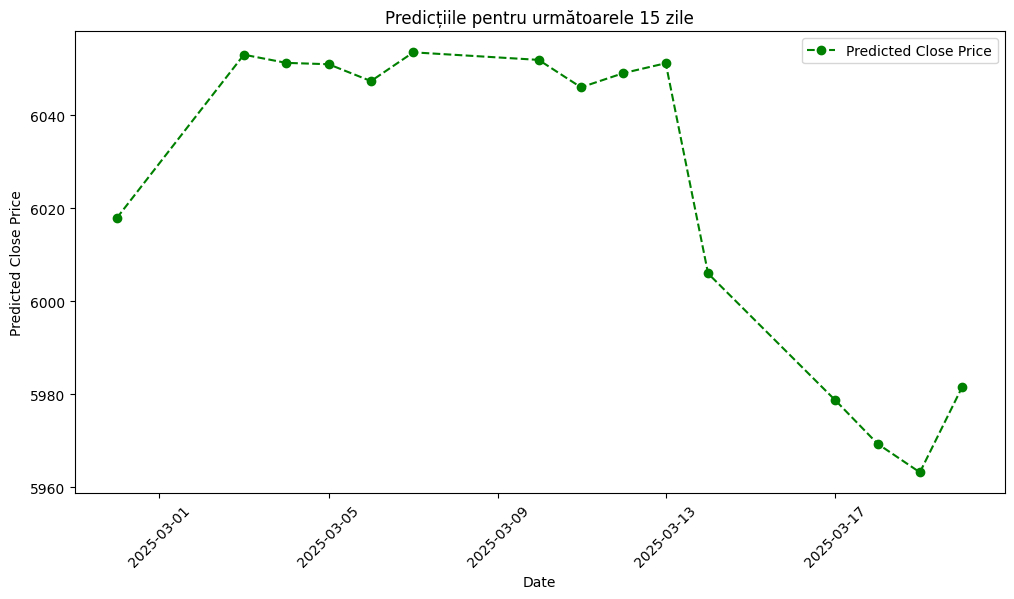

In [100]:
# 13. Vizualizarea predicțiilor pentru următoarele 15 zile
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', linestyle='dashed', color='green', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.title('Predicțiile pentru următoarele 15 zile')
plt.legend()
plt.xticks(rotation=45)
plt.show()